In [1]:
# import packages
import pandas as pd
import os
import csv
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.models import ldaseqmodel
import time
from gensim.models.wrappers import DtmModel
import pickle
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.colors as mcolors

In [2]:
# read in csv file
all_data = pd.read_csv('./all_data.csv', header=None)
# add columns
all_data.columns = ["year", "title", "article"]
# sort by year
all_data = all_data.sort_values(by=['year'])
# change index
new_index = np.arange(0, len(all_data))
all_data["new_index"] = new_index
all_data = all_data.set_index('new_index')

In [3]:
# construct the stop word list
stopwords = [line.strip() for line in open("stop_words_copy2.txt",encoding='UTF-8').readlines()]

In [4]:
# construct the function that preprocess the text
def preprocess(text):
    '''
    Preprocess the text by tokenizing the string into uni-grams, deleting all 
    numbers, punctuations and stop words. Store the preprocessed sting into 
    a list of words
    
    input: 
        text: text for preprocessing(str)
    output: a list of words
    '''
    result = []
    tokens = gensim.utils.tokenize(text)
    tokens_lst = list(tokens)
    for token in tokens_lst:
        if token not in stopwords:
            result.append(token)
            
    return result

In [5]:
# preprocess the data
processed_df = all_data['article'].map(preprocess)

In [6]:
# prepare Document-Term Matrix for the DTA model 
# Create Dictionaries for unique word counts of each decade
dic_all = corpora.Dictionary(processed_df)

# Create Corpus: Term Document Frequency
corpus_all = [dic_all.doc2bow(text) for text in processed_df]

In [7]:
# set the time slice
all_data[all_data['year']==1958]
# before 60s: 0-35
all_data[all_data['year']==1978]
# before 1979: 36-70
all_data[all_data['year']==1989]
# before 1990: 71-876
all_data[all_data['year']==2003]
# before 2003: 877-1811
time_slice = [71, 806, 935]

In [8]:
path_to_dtm_binary = "./dtm-linux64.dms"

In [9]:
# Construct the function that builds the lda model with 10 topics
def dtm_model(corpus, dictionary, num_topics, time_slice):
    '''
    Build a lda model with 10 topics using the corpus and dictionary
    imput:
        corpus: the Term Document Frequency corpus used to build the mode
        dictionary: a dictionary containing word counts of each unique word
                    in the dataframe for each decade
    output: a lda model object
    '''
    dtm_model = DtmModel(path_to_dtm_binary, corpus=corpus, time_slices=time_slice, \
                         num_topics=num_topics,id2word=dictionary, rng_seed=100)
    return dtm_model

In [8]:
# fit the model
start = time.time()
dtm_10 = dtm_model(corpus_all, dic_all, 10, time_slice)
end = time.time()
print(end - start)

NameError: name 'dtm_model' is not defined

In [35]:
dtm_5 = pickle.load(open("ldaseq_model.sav", 'rb'))

In [70]:
topics_dtm_5 = dtm_5.dtm_coherence(time=1)
cm_DTM = CoherenceModel(topics=topics_dtm_5, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.0184342296330713


In [9]:
# fit the 10-topic model
start = time.time()
ldaseq_10 = ldaseqmodel.LdaSeqModel(corpus=corpus_all, id2word=dic_all, time_slice=time_slice, num_topics=10)
end = time.time()
print(end - start)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


17645.63276195526


In [13]:
# save model
pickle.dump(ldaseq_10, open("ldaseq_model_10.sav", 'wb'))
# check
loaded_model_10 = pickle.load(open("ldaseq_model_10.sav", 'rb'))

NameError: name 'ldaseq_10' is not defined

In [40]:
# check
loaded_model_10 = pickle.load(open("ldaseq_model_10.sav", 'rb'))

In [42]:
# calculate coherence matrix
topics_dtm_10 = loaded_model_10.dtm_coherence(time=0)
cm_DTM = CoherenceModel(topics=topics_dtm_10, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.1267779631703594


In [20]:
# print the first period (pre 1979)
first_period = ldaseq_10.print_topics(time=0)
first_period

[[('人口', 0.07044011391455908),
  ('发展', 0.03212724088126665),
  ('经济', 0.015670058053402644),
  ('增长', 0.014933569531724188),
  ('社会', 0.013791119278192515),
  ('问题', 0.013208117751693315),
  ('资源', 0.006955607605569462),
  ('世界', 0.006891711411821534),
  ('城市', 0.00688562063825718),
  ('中国', 0.006571154126188291),
  ('环境', 0.005985000851009634),
  ('持续', 0.005965706589814484),
  ('提高', 0.0058253272788478215),
  ('地区', 0.004767395138293136),
  ('增加', 0.004737527107598841),
  ('水平', 0.004676346459132804),
  ('高', 0.004646891119548609),
  ('占', 0.004602968749656407),
  ('国家', 0.004487546871806497),
  ('解决', 0.004392143942600883)],
 [('人口', 0.016073668780779326),
  ('人', 0.015775779112891155),
  ('生产', 0.012209643140856794),
  ('我国', 0.009669379097010917),
  ('增加', 0.00961450029840283),
  ('平均', 0.0089777256696764),
  ('增长', 0.008877390679896183),
  ('生育', 0.007732360418673885),
  ('问题', 0.007370004387919109),
  ('孩子', 0.007100062730931866),
  ('生', 0.006701694307698201),
  ('岁', 0.006605

In [22]:
# print the second period
# print topics of the second time period (1980s)
second_period = ldaseq_10.print_topics(time=1)
second_period

[[('人口', 0.07215431864841855),
  ('发展', 0.03260532145200407),
  ('经济', 0.015755767854712253),
  ('增长', 0.014659310405805424),
  ('社会', 0.013901865836030983),
  ('问题', 0.013140379658351851),
  ('资源', 0.007098475275367026),
  ('城市', 0.006912530915946427),
  ('世界', 0.006856742438397656),
  ('中国', 0.006613659104759338),
  ('持续', 0.006165262699322873),
  ('环境', 0.006097832098788117),
  ('提高', 0.005866733151001197),
  ('增加', 0.004959327289923502),
  ('占', 0.00484976406624263),
  ('高', 0.004837042895461679),
  ('地区', 0.0047998890575028565),
  ('水平', 0.004695687632224133),
  ('国家', 0.004432862482225496),
  ('解决', 0.004377356065118538)],
 [('人口', 0.01619583608188276),
  ('人', 0.015898964629489563),
  ('生产', 0.0123421851201752),
  ('增加', 0.009808554152347607),
  ('我国', 0.009745107279821951),
  ('平均', 0.009075860221834053),
  ('增长', 0.008990422533611512),
  ('问题', 0.007342687825174518),
  ('生育', 0.007294821094062583),
  ('孩子', 0.007179389833001094),
  ('生', 0.006783658134194607),
  ('岁', 0.006716

In [23]:
# print topics of the third time period (1990s)
third_period = ldaseq_10.print_topics(time=2)
third_period

[[('人口', 0.058179073956352585),
  ('发展', 0.03388559130402996),
  ('经济', 0.016202032967118186),
  ('社会', 0.014344453120308812),
  ('问题', 0.013293729284627527),
  ('增长', 0.012932735834688245),
  ('资源', 0.007548870888007063),
  ('城市', 0.007077591195087214),
  ('世界', 0.00695579768799344),
  ('中国', 0.006851334095542709),
  ('持续', 0.0066642881087955585),
  ('环境', 0.0064073591097044205),
  ('提高', 0.006044765821354888),
  ('地区', 0.0049503839711663895),
  ('水平', 0.004812554636382315),
  ('增加', 0.0047798280318509904),
  ('占', 0.0047449484211176465),
  ('高', 0.004576730208087994),
  ('亿', 0.004469229301025177),
  ('国家', 0.004455910295390735)],
 [('人口', 0.016309306938904682),
  ('人', 0.016017790848713662),
  ('生产', 0.012448237899621776),
  ('增加', 0.009949797808331853),
  ('我国', 0.009700763226634065),
  ('平均', 0.009161679735612153),
  ('增长', 0.009085982232539109),
  ('生育', 0.007427853493431441),
  ('问题', 0.0073376839732916845),
  ('孩子', 0.007253596718148721),
  ('生', 0.006858620259593076),
  ('岁', 

In [24]:
# print topic evolution
# evolution of 1st topic
first_topic = ldaseq_10.print_topic_times(topic=0) 
first_topic

[[('人口', 0.07044011391455908),
  ('发展', 0.03212724088126665),
  ('经济', 0.015670058053402644),
  ('增长', 0.014933569531724188),
  ('社会', 0.013791119278192515),
  ('问题', 0.013208117751693315),
  ('资源', 0.006955607605569462),
  ('世界', 0.006891711411821534),
  ('城市', 0.00688562063825718),
  ('中国', 0.006571154126188291),
  ('环境', 0.005985000851009634),
  ('持续', 0.005965706589814484),
  ('提高', 0.0058253272788478215),
  ('地区', 0.004767395138293136),
  ('增加', 0.004737527107598841),
  ('水平', 0.004676346459132804),
  ('高', 0.004646891119548609),
  ('占', 0.004602968749656407),
  ('国家', 0.004487546871806497),
  ('解决', 0.004392143942600883)],
 [('人口', 0.07215431864841855),
  ('发展', 0.03260532145200407),
  ('经济', 0.015755767854712253),
  ('增长', 0.014659310405805424),
  ('社会', 0.013901865836030983),
  ('问题', 0.013140379658351851),
  ('资源', 0.007098475275367026),
  ('城市', 0.006912530915946427),
  ('世界', 0.006856742438397656),
  ('中国', 0.006613659104759338),
  ('持续', 0.006165262699322873),
  ('环境', 0.00

In [27]:
# evolution of 2nd topic
second_topic = ldaseq_10.print_topic_times(topic=1) 
second_topic

[[('人口', 0.016073668780779326),
  ('人', 0.015775779112891155),
  ('生产', 0.012209643140856794),
  ('我国', 0.009669379097010917),
  ('增加', 0.00961450029840283),
  ('平均', 0.0089777256696764),
  ('增长', 0.008877390679896183),
  ('生育', 0.007732360418673885),
  ('问题', 0.007370004387919109),
  ('孩子', 0.007100062730931866),
  ('生', 0.006701694307698201),
  ('岁', 0.0066050827347741555),
  ('生活', 0.005993488863870001),
  ('每年', 0.005700316414605513),
  ('人民', 0.005619783040818375),
  ('农业', 0.005229863718435157),
  ('家庭', 0.005138966588968502),
  ('国家', 0.005048335926170881),
  ('提高', 0.004823175647374086),
  ('粮食', 0.004783176974104591)],
 [('人口', 0.01619583608188276),
  ('人', 0.015898964629489563),
  ('生产', 0.0123421851201752),
  ('增加', 0.009808554152347607),
  ('我国', 0.009745107279821951),
  ('平均', 0.009075860221834053),
  ('增长', 0.008990422533611512),
  ('问题', 0.007342687825174518),
  ('生育', 0.007294821094062583),
  ('孩子', 0.007179389833001094),
  ('生', 0.006783658134194607),
  ('岁', 0.0067168

In [29]:
# evolution of 3rd topic
third_topic = ldaseq_10.print_topic_times(topic=2) 
third_topic

[[('计划生育', 0.05918448641154572),
  ('工作', 0.05062229438730188),
  ('群众', 0.016694895917644437),
  ('宣传', 0.011287767595107702),
  ('协会', 0.010367250861932726),
  ('干部', 0.009355739589480794),
  ('领导', 0.00844706877371619),
  ('全国', 0.006884970871143747),
  ('计生', 0.006724225552581118),
  ('服务', 0.006157635672466006),
  ('新', 0.006073548488116918),
  ('教育', 0.0058565465199890724),
  ('各级', 0.005832208785566449),
  ('基层', 0.005633419035724777),
  ('加强', 0.005343538048361407),
  ('思想', 0.005300768306359272),
  ('先进', 0.005076858792814353),
  ('开展', 0.005074334209104178),
  ('抓', 0.004999062952211988),
  ('会议', 0.0048476187301332895)],
 [('计划生育', 0.06748762977178856),
  ('工作', 0.05042099155490915),
  ('群众', 0.01674023808267892),
  ('宣传', 0.011197386392414717),
  ('协会', 0.010507131040595044),
  ('干部', 0.008429326389372618),
  ('领导', 0.00837731535537986),
  ('全国', 0.006893335054272378),
  ('计生', 0.0068260810505116785),
  ('服务', 0.0062294030038314),
  ('新', 0.006091239260594674),
  ('教育', 0.0

In [31]:
# evolution of 4th topic
fourth_topic = ldaseq_10.print_topic_times(topic=3) 
fourth_topic

[[('计划生育', 0.029247642376217575),
  ('人口', 0.02410989860356437),
  ('万', 0.014056215916530152),
  ('工作', 0.011175631321288473),
  ('增长率', 0.009534194503180719),
  ('去年', 0.008379517219949825),
  ('自然', 0.008200906458903298),
  ('生育', 0.007825209571520863),
  ('农村', 0.007421219410328785),
  ('全省', 0.007398944717416805),
  ('县', 0.0073133286618306155),
  ('责任制', 0.007221847983670644),
  ('管理', 0.006977974631066138),
  ('生产', 0.006846269128873217),
  ('人', 0.006832457123776688),
  ('实行', 0.006418918617685854),
  ('计划', 0.006375030914184514),
  ('保险', 0.005972651846792435),
  ('服务', 0.005969375403918669),
  ('元', 0.005773296620855325)],
 [('计划生育', 0.028658065056668413),
  ('人口', 0.02443287563732102),
  ('万', 0.014252795231785506),
  ('工作', 0.011326963584806145),
  ('增长率', 0.008010254288361888),
  ('生育', 0.00789927232184031),
  ('管理', 0.007702599736042424),
  ('农村', 0.0075055057846061864),
  ('全省', 0.007478929058608533),
  ('县', 0.007371722421617475),
  ('去年', 0.007289780142849802),
  ('自然'

In [32]:
# evolution of 5th topic
fifth_topic = ldaseq_10.print_topic_times(topic=4) 
fifth_topic

[[('人口', 0.07495285833334345),
  ('中国', 0.022131501400502553),
  ('世界', 0.019236122564590515),
  ('增长', 0.013789291360029722),
  ('国家', 0.01352208772446121),
  ('国际', 0.013354930286330072),
  ('会议', 0.01121266835282075),
  ('问题', 0.011090215115733807),
  ('联合国', 0.01083142646536086),
  ('发展', 0.010761753613316563),
  ('计划生育', 0.010249787690368366),
  ('控制', 0.009121708389283105),
  ('亿', 0.009015940081055643),
  ('政府', 0.008982518920545452),
  ('政策', 0.00830233022445664),
  ('亚洲', 0.006886561203308084),
  ('人', 0.006465331916658413),
  ('代表', 0.0060761108520387755),
  ('美国', 0.005992822392274204),
  ('各国', 0.005829282606939825)],
 [('人口', 0.0756600818312705),
  ('中国', 0.02368671879710511),
  ('世界', 0.019465727256727475),
  ('增长', 0.013855516629844867),
  ('国际', 0.013651620826926492),
  ('国家', 0.013580482397062955),
  ('会议', 0.01125819537110394),
  ('问题', 0.011169799611089702),
  ('联合国', 0.010971859715701872),
  ('发展', 0.010877008552317177),
  ('计划生育', 0.010328905464980841),
  ('控制', 0.

In [33]:
# evolution of 6th topic
sixth_topic = ldaseq_10.print_topic_times(topic=5) 
sixth_topic

[[('人口', 0.057078284087703796),
  ('我国', 0.019915464429290607),
  ('计划生育', 0.01949966935488804),
  ('工作', 0.016919869447917582),
  ('控制', 0.014828887041762323),
  ('增长', 0.013943793145230449),
  ('发展', 0.012768206700214207),
  ('经济', 0.00959486904456213),
  ('社会', 0.008366476166126055),
  ('生育', 0.008364600430979075),
  ('问题', 0.007807055740813231),
  ('政策', 0.007364850457071684),
  ('全国', 0.007356895050228631),
  ('水平', 0.006763431567083178),
  ('提高', 0.006158008556833964),
  ('国家', 0.0053574875410632074),
  ('出生', 0.005048125593182324),
  ('实现', 0.0047940781293120465),
  ('必须', 0.004744662582671363),
  ('环境', 0.004518782113172572)],
 [('人口', 0.05757087680391414),
  ('我国', 0.020016767627034124),
  ('计划生育', 0.019687563476286234),
  ('工作', 0.017141914204055315),
  ('控制', 0.013901682968988192),
  ('发展', 0.012933989223064555),
  ('增长', 0.012732803523645374),
  ('经济', 0.009694795355930527),
  ('社会', 0.008530062673395981),
  ('生育', 0.008419681541242827),
  ('问题', 0.007698568688760564),
  ('

In [34]:
# evolution of 7th topic
seventh_topic = ldaseq_10.print_topic_times(topic=6) 
seventh_topic

[[('孩子', 0.02242742826583915),
  ('生', 0.017694485514162417),
  ('计划生育', 0.012638173152585778),
  ('人', 0.009219985291022262),
  ('夫妇', 0.007246798812393834),
  ('妇女', 0.006989022198399595),
  ('大队', 0.0068859631807402025),
  ('群众', 0.006772771290448951),
  ('工作', 0.006521110589056569),
  ('农民', 0.006502488817660084),
  ('少', 0.006416706009564076),
  ('教育', 0.006015475078985495),
  ('元', 0.005080296278781145),
  ('干部', 0.004810625948883908),
  ('生育', 0.004717343303381513),
  ('计生', 0.00463683483388115),
  ('农村', 0.004356228139837498),
  ('观念', 0.004233397187878021),
  ('富', 0.004170979468200818),
  ('胎', 0.004151081240992724)],
 [('生', 0.01788355998826645),
  ('孩子', 0.017358930636394716),
  ('计划生育', 0.01277487877052146),
  ('人', 0.009027279523380364),
  ('妇女', 0.007063439283702878),
  ('夫妇', 0.006996894517089877),
  ('群众', 0.006870271058542766),
  ('农民', 0.00664031291925394),
  ('工作', 0.006592284301635169),
  ('少', 0.006565820519918213),
  ('大队', 0.006490261587377099),
  ('教育', 0.00610

In [35]:
# evolution of 8th topic
eighth_topic = ldaseq_10.print_topic_times(topic=7) 
eighth_topic

[[('计划生育', 0.020189144606385788),
  ('人', 0.01475450963837376),
  ('工作', 0.012243392979131911),
  ('流动', 0.009603372207706937),
  ('胎', 0.009495244537985916),
  ('生育', 0.009275595916380228),
  ('超生', 0.00836032881755665),
  ('人口', 0.007354722907365415),
  ('生', 0.0063717817539568735),
  ('妇女', 0.00546636841126169),
  ('部门', 0.005433317132495005),
  ('人员', 0.0053405427348694615),
  ('干部', 0.005280392030753855),
  ('出生', 0.004855754110120875),
  ('育龄', 0.004776662012927697),
  ('调查', 0.004713354894315926),
  ('统计', 0.004648279025546136),
  ('外', 0.004518187754580191),
  ('措施', 0.004425959646211638),
  ('进行', 0.004370086239400245)],
 [('计划生育', 0.021797129865162017),
  ('人', 0.014832229522692452),
  ('工作', 0.012284286930516383),
  ('流动', 0.009766858247616781),
  ('生育', 0.009295145687429422),
  ('超生', 0.008786891992419804),
  ('胎', 0.008313719230913303),
  ('人口', 0.007433573469212904),
  ('生', 0.005754450142692591),
  ('部门', 0.005518467418935917),
  ('人员', 0.005498850662175436),
  ('妇女', 0.

In [36]:
# evolution of 9th topic
ninth_topic = ldaseq_10.print_topic_times(topic=8) 
ninth_topic

[[('节育', 0.0210096313317803),
  ('手术', 0.01949765563043628),
  ('研究', 0.01741821486194611),
  ('避孕', 0.016403730398859503),
  ('理论', 0.011243155241190206),
  ('方法', 0.008920793152771403),
  ('人', 0.0084485040778737),
  ('技术', 0.007973637062509894),
  ('认为', 0.007077250218834372),
  ('科学', 0.006306060664651073),
  ('种', 0.006076171395879671),
  ('我国', 0.005909186759693054),
  ('医院', 0.005899869497668031),
  ('进行', 0.005633000472969327),
  ('生态', 0.005143065487475419),
  ('新', 0.0051242596890007834),
  ('问题', 0.004782487209178527),
  ('结扎', 0.0043805670571146395),
  ('使用', 0.0040432758715125226),
  ('马尔萨斯', 0.0039057846632004323)],
 [('节育', 0.021139578145833275),
  ('手术', 0.019449269245982097),
  ('研究', 0.01755550018782779),
  ('避孕', 0.01629343849273596),
  ('理论', 0.011103729149172334),
  ('方法', 0.008898591233677044),
  ('人', 0.008459043004660329),
  ('技术', 0.008147819356466138),
  ('认为', 0.007114477256655199),
  ('科学', 0.00629973549795842),
  ('种', 0.006238385454836567),
  ('我国', 0.0059

In [37]:
# evolution of 10th topic
tenth_topic = ldaseq_10.print_topic_times(topic=9) 
tenth_topic

[[('计划生育', 0.03750753913920411),
  ('人口', 0.024640235993731385),
  ('国家', 0.01179758967409812),
  ('服务', 0.01067424566506121),
  ('技术', 0.010648558339324491),
  ('中国', 0.008595722982708397),
  ('全国', 0.00803296315034466),
  ('健康', 0.007732036108345835),
  ('我国', 0.007409228543143996),
  ('规定', 0.007312019970134711),
  ('社会', 0.007144589959104045),
  ('教育', 0.006825426873211588),
  ('文化', 0.006498423640634047),
  ('法律', 0.00648766846124253),
  ('工作', 0.006412479927016965),
  ('北京', 0.006235832735332146),
  ('研究', 0.006186246548629616),
  ('科技', 0.005785201416711324),
  ('妇女', 0.005529619515779615),
  ('生育', 0.005144208702711765)],
 [('计划生育', 0.03786986431767568),
  ('人口', 0.024871586881893348),
  ('国家', 0.011831121358000326),
  ('服务', 0.010915346728120112),
  ('技术', 0.010835405915971758),
  ('中国', 0.008707907115851655),
  ('全国', 0.008077891937450541),
  ('健康', 0.007706057094564323),
  ('规定', 0.0073721966884492925),
  ('我国', 0.0072548829360546425),
  ('社会', 0.007224400441307131),
  ('教育'

In [8]:
# fit the 8-topic model
start = time.time()
ldaseq_8 = ldaseqmodel.LdaSeqModel(corpus=corpus_all, id2word=dic_all, \
                                    time_slice=time_slice, num_topics=8, chain_variance=0.1)
end = time.time()
print(end - start)

/Users/ditong/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


8986.298130273819


In [13]:
# save model
pickle.dump(ldaseq_8, open("ldaseq_model_8.sav", 'wb'))
# check
loaded_model_8 = pickle.load(open("ldaseq_model_8.sav", 'rb'))

NameError: name 'ldaseq_8' is not defined

In [14]:
loaded_model_8 = pickle.load(open("ldaseq_model_8.sav", 'rb'))

In [23]:
# calculate coherence matrix
topics_dtm_8 = loaded_model_8.dtm_coherence(time=2)
cm_DTM_8 = CoherenceModel(topics=topics_dtm_8, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_8.get_coherence())

U_mass topic coherence
DTM Python coherence is -0.9821029079226468


In [10]:
# print the first period (pre 1979)
first_period = ldaseq_8.print_topics(time=0)
first_period

[[('工作', 0.05022037420943482),
  ('群众', 0.017583965051063865),
  ('计划生育', 0.014646158341702752),
  ('干部', 0.013516684269124753),
  ('部门', 0.009595757278930608),
  ('人', 0.008277443683807013),
  ('宣传', 0.007502490601990618),
  ('人员', 0.005828336056643702),
  ('县', 0.00541582429412901),
  ('管理', 0.005312017355609506),
  ('生育', 0.0053012324513123455),
  ('基层', 0.0051147155458321335),
  ('流动', 0.005025686235358013),
  ('超生', 0.0046387358844503625),
  ('服务', 0.004215086098221059),
  ('村', 0.004032994899107086),
  ('协会', 0.003715171502233683),
  ('主任', 0.0035886147552833584),
  ('开展', 0.0035024910930927045),
  ('进行', 0.0033229628970627193)],
 [('人', 0.09092766498996013),
  ('元', 0.053275725742351066),
  ('孩子', 0.02778150439611761),
  ('生', 0.025034660555301354),
  ('生活', 0.020549193250444377),
  ('住', 0.01703607691022935),
  ('户', 0.016799129981061634),
  ('生育', 0.01582930512865436),
  ('农村', 0.009603420461070758),
  ('少', 0.008302279305494422),
  ('农民', 0.007738461432227956),
  ('家庭', 0.006

In [20]:
# print the second period
# print topics of the second time period (1980s)
second_period = ldaseq_8.print_topics(time=1)
second_period

[[('计划生育', 0.03712979281791407),
  ('工作', 0.020172355617737264),
  ('干部', 0.009091705214427993),
  ('群众', 0.009039297990606586),
  ('人', 0.008621164256770996),
  ('管理', 0.006921448811215725),
  ('超生', 0.006852236680348207),
  ('流动', 0.006443267159396035),
  ('县', 0.005865545132056023),
  ('人员', 0.005670195652248116),
  ('部门', 0.0055297716830761505),
  ('生育', 0.0048288637265136965),
  ('服务', 0.004697463670407722),
  ('协会', 0.004627925245312628),
  ('村', 0.004525775606946752),
  ('基层', 0.004286670463236879),
  ('育龄', 0.00406171624008532),
  ('计划', 0.003595617916219236),
  ('人口', 0.0035027407888136787),
  ('外', 0.003459950139894911)],
 [('人', 0.029055940695869555),
  ('元', 0.028548291903994737),
  ('生', 0.024895480004555784),
  ('孩子', 0.02111920950838357),
  ('农民', 0.013176324855968419),
  ('少', 0.012025655856954085),
  ('农村', 0.01142720451901208),
  ('生活', 0.01103668139323813),
  ('户', 0.009840852235944162),
  ('生育', 0.008575071705748201),
  ('人均', 0.007965619763435182),
  ('家庭', 0.00787

In [21]:
# print topics of the third time period (1990s)
third_period = ldaseq_8.print_topics(time=2)
third_period

[[('计划生育', 0.033356925499793494),
  ('工作', 0.022947357124948307),
  ('计生', 0.0193577080581032),
  ('服务', 0.016395225980404226),
  ('协会', 0.016266557362700523),
  ('群众', 0.013736053186629122),
  ('管理', 0.009213341709342855),
  ('流动', 0.007499809998127005),
  ('教育', 0.00599571917752917),
  ('干部', 0.0058023553253214915),
  ('人', 0.005758215955333598),
  ('育龄', 0.005475316001442726),
  ('宣传', 0.005385525570355824),
  ('基层', 0.005300557978589398),
  ('开展', 0.005129463360802414),
  ('技术', 0.0051009147555851845),
  ('部门', 0.004808623141354231),
  ('人员', 0.004739605396966664),
  ('万', 0.004636150585299858),
  ('科技', 0.004403837706837105)],
 [('生', 0.025361595517184424),
  ('农民', 0.01934933384711254),
  ('少', 0.01929073396004858),
  ('元', 0.01361889792322048),
  ('富', 0.013495628721716339),
  ('农村', 0.011383074494433128),
  ('快', 0.011129323523316309),
  ('致富', 0.01022906807407179),
  ('家庭', 0.010197065441025518),
  ('户', 0.00977231037913803),
  ('人', 0.009422064045915156),
  ('孩子', 0.008740183

In [22]:
# print topic evolution
# evolution of 1st topic
first_topic = ldaseq_8.print_topic_times(topic=0) 
first_topic

[[('工作', 0.05022037420943482),
  ('群众', 0.017583965051063865),
  ('计划生育', 0.014646158341702752),
  ('干部', 0.013516684269124753),
  ('部门', 0.009595757278930608),
  ('人', 0.008277443683807013),
  ('宣传', 0.007502490601990618),
  ('人员', 0.005828336056643702),
  ('县', 0.00541582429412901),
  ('管理', 0.005312017355609506),
  ('生育', 0.0053012324513123455),
  ('基层', 0.0051147155458321335),
  ('流动', 0.005025686235358013),
  ('超生', 0.0046387358844503625),
  ('服务', 0.004215086098221059),
  ('村', 0.004032994899107086),
  ('协会', 0.003715171502233683),
  ('主任', 0.0035886147552833584),
  ('开展', 0.0035024910930927045),
  ('进行', 0.0033229628970627193)],
 [('计划生育', 0.03712979281791407),
  ('工作', 0.020172355617737264),
  ('干部', 0.009091705214427993),
  ('群众', 0.009039297990606586),
  ('人', 0.008621164256770996),
  ('管理', 0.006921448811215725),
  ('超生', 0.006852236680348207),
  ('流动', 0.006443267159396035),
  ('县', 0.005865545132056023),
  ('人员', 0.005670195652248116),
  ('部门', 0.0055297716830761505),
  ('

In [23]:
# evolution of 2nd topic
second_topic = ldaseq_8.print_topic_times(topic=1) 
second_topic

[[('人', 0.09092766498996013),
  ('元', 0.053275725742351066),
  ('孩子', 0.02778150439611761),
  ('生', 0.025034660555301354),
  ('生活', 0.020549193250444377),
  ('住', 0.01703607691022935),
  ('户', 0.016799129981061634),
  ('生育', 0.01582930512865436),
  ('农村', 0.009603420461070758),
  ('少', 0.008302279305494422),
  ('农民', 0.007738461432227956),
  ('家庭', 0.006661318745309229),
  ('村', 0.005350162048136066),
  ('胎', 0.005193160746938287),
  ('万', 0.005181018307259381),
  ('人均', 0.004885417614129388),
  ('房子', 0.004708097782681737),
  ('收入', 0.004523421827302519),
  ('越', 0.004420547227592286),
  ('老人', 0.004294145710400956)],
 [('人', 0.029055940695869555),
  ('元', 0.028548291903994737),
  ('生', 0.024895480004555784),
  ('孩子', 0.02111920950838357),
  ('农民', 0.013176324855968419),
  ('少', 0.012025655856954085),
  ('农村', 0.01142720451901208),
  ('生活', 0.01103668139323813),
  ('户', 0.009840852235944162),
  ('生育', 0.008575071705748201),
  ('人均', 0.007965619763435182),
  ('家庭', 0.007876739958673709

In [25]:
# evolution of 3rd topic
third_topic = ldaseq_8.print_topic_times(topic=2) 
third_topic

[[('人口', 0.04724034554040581),
  ('世界', 0.019224441882210404),
  ('问题', 0.01661453147858668),
  ('国家', 0.016453069456339113),
  ('会议', 0.015876718534270255),
  ('代表', 0.01082104993579729),
  ('人民', 0.010593888613809535),
  ('中国', 0.009284446978690415),
  ('国际', 0.008732458468712139),
  ('经济', 0.008172134451207647),
  ('政策', 0.00814960720198475),
  ('指出', 0.007932546905719132),
  ('联合国', 0.006554437360040921),
  ('代表团', 0.006428051197145927),
  ('发言', 0.006270485720667111),
  ('各国', 0.006194069476663684),
  ('发展', 0.00586190948376508),
  ('超级大国', 0.005491745230943282),
  ('第三世界', 0.005200123822487517),
  ('研究', 0.004940039037853165)],
 [('人口', 0.05532513566133914),
  ('中国', 0.03396948367362931),
  ('世界', 0.014873845134710496),
  ('计划生育', 0.01419661228087385),
  ('联合国', 0.013852955398245432),
  ('国际', 0.0123935311364354),
  ('国家', 0.009789308346359124),
  ('会议', 0.009554377774813487),
  ('美国', 0.009381912390343668),
  ('政策', 0.00886920904875247),
  ('问题', 0.008445425917615226),
  ('研究', 

In [26]:
# evolution of 4th topic
fourth_topic = ldaseq_8.print_topic_times(topic=3) 
fourth_topic

[[('避孕', 0.03203082545095527),
  ('生育', 0.013519306383928703),
  ('人口', 0.011141657773426938),
  ('人', 0.01016001158092708),
  ('工作', 0.008466138789806742),
  ('问题', 0.008230946844420703),
  ('国家', 0.007895657154000589),
  ('方法', 0.007409740960600484),
  ('目前', 0.005896849746167176),
  ('手术', 0.0058274755951167895),
  ('卫生', 0.005731538661453813),
  ('增长', 0.005379357091325843),
  ('要求', 0.005108231180913277),
  ('计划', 0.004778556886654057),
  ('亿', 0.004618732517453728),
  ('增加', 0.004616753203705908),
  ('节育', 0.004603116729901086),
  ('方面', 0.004420194183397565),
  ('报告', 0.004039134989785988),
  ('增长率', 0.004013642246649685)],
 [('人口', 0.07537023941670284),
  ('增长', 0.01845537140067546),
  ('人', 0.011285066460521053),
  ('亿', 0.01040569729596401),
  ('国家', 0.010195129976183452),
  ('世界', 0.009994021740573001),
  ('生育', 0.009782932919630423),
  ('控制', 0.009612470026928388),
  ('增长率', 0.00921218817473163),
  ('万', 0.009041836820146197),
  ('下降', 0.007273312991219573),
  ('问题', 0.0071

In [30]:
# evolution of 5th topic
fifth_topic = ldaseq_8.print_topic_times(topic=4) 
fifth_topic

[[('计划生育', 0.05663368663556687),
  ('工作', 0.0433521304044605),
  ('思想', 0.010885104267934487),
  ('群众', 0.009829884769973438),
  ('领导', 0.009092603398236901),
  ('晚婚', 0.008352269434194001),
  ('宣传', 0.007604715011739022),
  ('实行', 0.007207649823205036),
  ('大队', 0.007146214472714889),
  ('抓', 0.0067572571053818725),
  ('开展', 0.006738945463355246),
  ('计划', 0.00639658100188381),
  ('公社', 0.006194925475722688),
  ('革命', 0.0061481456857386905),
  ('措施', 0.006125745294229703),
  ('干部', 0.0059093444170557775),
  ('新', 0.005798490273191898),
  ('深入', 0.005503857165288462),
  ('节育', 0.005374845341610736),
  ('生育', 0.005332866744925992)],
 [('计划生育', 0.0447054924345026),
  ('工作', 0.030457067233026932),
  ('干部', 0.010318584980914307),
  ('群众', 0.010299895461612084),
  ('生', 0.009447055203384555),
  ('夫妇', 0.009269042428185862),
  ('人口', 0.008653424902165726),
  ('孩子', 0.008348071734262318),
  ('措施', 0.008029861252401944),
  ('思想', 0.007373086768109459),
  ('生育', 0.007371207005176895),
  ('宣传', 

In [31]:
# evolution of 6th topic
sixth_topic = ldaseq_8.print_topic_times(topic=5) 
sixth_topic

[[('人口', 0.04323992759744855),
  ('工作', 0.02792401550360703),
  ('发展', 0.0186279481459347),
  ('人民', 0.01632783997057166),
  ('计划生育', 0.016244368503573303),
  ('增长', 0.015274378435700602),
  ('全国', 0.012801051018441905),
  ('计划', 0.011468443256829006),
  ('我国', 0.010860548491780022),
  ('群众', 0.0099208630562215),
  ('国家', 0.00963985242104843),
  ('控制', 0.008764962312712255),
  ('会议', 0.00859100970032241),
  ('政策', 0.008123697698402774),
  ('代表', 0.007400193596862202),
  ('经济', 0.007372347365668645),
  ('必须', 0.007190901051199469),
  ('问题', 0.007174178854740664),
  ('加强', 0.006287620675950881),
  ('社会', 0.006107119271288415)],
 [('人口', 0.03898275136347214),
  ('计划生育', 0.034236890459123426),
  ('工作', 0.023740015750081243),
  ('发展', 0.018031029985928877),
  ('控制', 0.01417382366483241),
  ('我国', 0.014126341225696679),
  ('问题', 0.011581258379238164),
  ('增长', 0.01057014091094099),
  ('全国', 0.01036158031160945),
  ('国家', 0.010086903858882515),
  ('政策', 0.009776970284129634),
  ('人民', 0.00924

In [32]:
# evolution of 7th topic
seventh_topic = ldaseq_8.print_topic_times(topic=6) 
seventh_topic

[[('妇女', 0.018365760375113616),
  ('节育', 0.010602746981243385),
  ('结婚', 0.00925502832635557),
  ('生育', 0.009104085877760152),
  ('宣传', 0.008682832969256581),
  ('青年', 0.008093513519050043),
  ('人', 0.0077940348031572265),
  ('子女', 0.007718816697312672),
  ('女', 0.007111174742001939),
  ('孩子', 0.0069921712345081795),
  ('学习', 0.0069842525895068485),
  ('生', 0.006348298868921754),
  ('手术', 0.006316113198719902),
  ('工作', 0.005934434421084677),
  ('健康', 0.005897982825094868),
  ('岁', 0.0052928032572792105),
  ('进行', 0.005212754595911973),
  ('家庭', 0.0051721563701326335),
  ('提倡', 0.0050303898934810284),
  ('思想', 0.004888047405713388)],
 [('妇女', 0.02105562262103092),
  ('手术', 0.01896000631713202),
  ('节育', 0.017008839190386253),
  ('生', 0.014711575119331756),
  ('岁', 0.013955883378108665),
  ('女', 0.012654249098394375),
  ('孩子', 0.012252828378665934),
  ('结婚', 0.010434790495818812),
  ('青年', 0.009195880423945426),
  ('生育', 0.008367939527821654),
  ('家庭', 0.006657724128612251),
  ('人', 0.0

In [33]:
# evolution of 8th topic
eightth_topic = ldaseq_8.print_topic_times(topic=7) 
eightth_topic

[[('人口', 0.024938202755604426),
  ('我国', 0.013681320102554226),
  ('生产', 0.012372498533843519),
  ('人', 0.012071328672355696),
  ('问题', 0.01183561268865091),
  ('增加', 0.00918077916018191),
  ('发展', 0.00844484022061606),
  ('农业', 0.0074874231839937334),
  ('工业', 0.006441116495553502),
  ('人民', 0.00617081459415617),
  ('社会主义', 0.00594495191793712),
  ('农民', 0.005634120385858037),
  ('建设', 0.005378469981553),
  ('平均', 0.00534304238393883),
  ('提高', 0.005314803099042725),
  ('生活', 0.004819976873257686),
  ('增长', 0.004785499283543049),
  ('积累', 0.004650666217110672),
  ('社会', 0.004494359902182897),
  ('粮食', 0.004488708822006752)],
 [('人口', 0.05265761494715603),
  ('增长', 0.017812054901598113),
  ('我国', 0.01526247159939904),
  ('发展', 0.014618223670683833),
  ('生产', 0.010780273980362071),
  ('人', 0.00989645742322999),
  ('经济', 0.009173637285825476),
  ('问题', 0.00857747662353845),
  ('增加', 0.008312374851750796),
  ('社会', 0.007472677021868531),
  ('粮食', 0.0068930566485542605),
  ('控制', 0.0068523

In [8]:
# fit the 6-topic model
start = time.time()
ldaseq_6 = ldaseqmodel.LdaSeqModel(corpus=corpus_all, id2word=dic_all, \
                                    time_slice=time_slice, num_topics=6, chain_variance=0.1)
end = time.time()
print(end - start)

/Users/ditong/anaconda3/lib/python3.6/site-packages/gensim/models/ldaseqmodel.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


7037.937752962112


In [24]:
# save model
pickle.dump(ldaseq_6, open("ldaseq_model_6.sav", 'wb'))
# check
loaded_model_6 = pickle.load(open("ldaseq_model_6.sav", 'rb'))

In [16]:
# check
loaded_model_6 = pickle.load(open("ldaseq_model_6.sav", 'rb'))
# calculate coherence matrix
topics_dtm_6 = loaded_model_6.dtm_coherence(time=1)
cm_DTM_6 = CoherenceModel(topics=topics_dtm_6, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_6.get_coherence())

U_mass topic coherence
DTM Python coherence is -1.0506722241462418


In [12]:
# calculate coherence matrix
topics_dtm_6 = ldaseq_6.dtm_coherence(time=1)
cm_DTM_6 = CoherenceModel(topics=topics_dtm_6, corpus=corpus_all, dictionary=dic_all, coherence='u_mass')
print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM_6.get_coherence())

NameError: name 'ldaseq_6' is not defined

In [10]:
# check
loaded_model_6 = pickle.load(open("ldaseq_model_6.sav", 'rb'))

In [28]:
# print the first period (pre 1979)
first_period = ldaseq_6.print_topics(time=0)
first_period

[[('计划生育', 0.020454827271764262),
  ('妇女', 0.014054302394111541),
  ('工作', 0.01305987513505376),
  ('大队', 0.009330334617488981),
  ('思想', 0.008877518311954687),
  ('青年', 0.008561747824567112),
  ('晚婚', 0.007836696991824384),
  ('革命', 0.007430428075030277),
  ('女', 0.007356300935391023),
  ('人', 0.007186450774653743),
  ('孩子', 0.00718300332764597),
  ('生产', 0.007119280698022227),
  ('生', 0.006784641351549463),
  ('实行', 0.006765009893252442),
  ('公社', 0.006377283361060908),
  ('群众', 0.006139829792520575),
  ('社员', 0.005439479443466397),
  ('农业', 0.005417648910648513),
  ('学习', 0.0053542070330738385),
  ('生育', 0.005024925727317897)],
 [('工作', 0.053711404258664795),
  ('计划生育', 0.0421778713022789),
  ('群众', 0.014637337502883829),
  ('宣传', 0.014165124163009739),
  ('人口', 0.01235616292432255),
  ('主席', 0.01087519528905669),
  ('领导', 0.009752470653668556),
  ('计划', 0.00892490119249469),
  ('毛', 0.007934349208648113),
  ('加强', 0.00745973071800059),
  ('开展', 0.007099521700309017),
  ('提高', 0.006

In [30]:
# print the second period
# print topics of the second time period (1980s)
second_period = ldaseq_6.print_topics(time=1)
second_period

[[('计划生育', 0.0238742696373759),
  ('工作', 0.016446954751593943),
  ('生', 0.015799387520546115),
  ('孩子', 0.01401499257820535),
  ('干部', 0.010870053809701553),
  ('群众', 0.010045314199662887),
  ('夫妇', 0.009067273117542912),
  ('人', 0.008730061195415665),
  ('大队', 0.007065677894157993),
  ('思想', 0.006961279239198513),
  ('胎', 0.006445955191409613),
  ('实行', 0.005776578969196942),
  ('生育', 0.005553433777597002),
  ('措施', 0.005329494119908529),
  ('农村', 0.00529444339393724),
  ('生产', 0.005094275846274671),
  ('公社', 0.004775426300362911),
  ('农民', 0.004683082206627368),
  ('教育', 0.00423679204843062),
  ('女', 0.004167124481490846)],
 [('计划生育', 0.05416000036203985),
  ('工作', 0.03846473551892147),
  ('人口', 0.020976090855631645),
  ('宣传', 0.011348236530620278),
  ('控制', 0.010813706247899716),
  ('群众', 0.010623991536684802),
  ('全国', 0.01039965166947375),
  ('我国', 0.010089332386315975),
  ('生育', 0.0076871430019393614),
  ('政策', 0.007425970124268018),
  ('教育', 0.006889441724067072),
  ('实行', 0.006

In [31]:
# print topics of the third time period (1990s)
third_period = ldaseq_6.print_topics(time=2)
third_period

[[('计划生育', 0.020863024111421206),
  ('生', 0.014174866425182259),
  ('农民', 0.01161223689645871),
  ('群众', 0.009831543508518507),
  ('保险', 0.009668910685300704),
  ('农村', 0.009570373751836716),
  ('孩子', 0.009105565012525513),
  ('富', 0.007227911474794097),
  ('元', 0.0070870654559637945),
  ('妇女', 0.00707264264329603),
  ('工作', 0.006990445479411177),
  ('人', 0.006853854818958171),
  ('生育', 0.006826230651408928),
  ('户', 0.006557319931925809),
  ('观念', 0.006067532473787957),
  ('村', 0.005876332287572776),
  ('家庭', 0.005721460224152306),
  ('夫妇', 0.005552197455839727),
  ('少', 0.005375350380215592),
  ('致富', 0.005062113614363796)],
 [('计划生育', 0.03704409756218003),
  ('工作', 0.033084975516339606),
  ('人口', 0.024336847741988462),
  ('发展', 0.010946588715720683),
  ('群众', 0.009684326348884111),
  ('环境', 0.007941185727672103),
  ('社会', 0.007446470437382613),
  ('全国', 0.007041806431726588),
  ('我国', 0.0070411720913071164),
  ('建设', 0.0065170158514262135),
  ('协会', 0.006406153165855841),
  ('新', 0.

In [32]:
# print topic evolution
# evolution of 1st topic
first_topic = ldaseq_6.print_topic_times(topic=0) 
first_topic

[[('计划生育', 0.020454827271764262),
  ('妇女', 0.014054302394111541),
  ('工作', 0.01305987513505376),
  ('大队', 0.009330334617488981),
  ('思想', 0.008877518311954687),
  ('青年', 0.008561747824567112),
  ('晚婚', 0.007836696991824384),
  ('革命', 0.007430428075030277),
  ('女', 0.007356300935391023),
  ('人', 0.007186450774653743),
  ('孩子', 0.00718300332764597),
  ('生产', 0.007119280698022227),
  ('生', 0.006784641351549463),
  ('实行', 0.006765009893252442),
  ('公社', 0.006377283361060908),
  ('群众', 0.006139829792520575),
  ('社员', 0.005439479443466397),
  ('农业', 0.005417648910648513),
  ('学习', 0.0053542070330738385),
  ('生育', 0.005024925727317897)],
 [('计划生育', 0.0238742696373759),
  ('工作', 0.016446954751593943),
  ('生', 0.015799387520546115),
  ('孩子', 0.01401499257820535),
  ('干部', 0.010870053809701553),
  ('群众', 0.010045314199662887),
  ('夫妇', 0.009067273117542912),
  ('人', 0.008730061195415665),
  ('大队', 0.007065677894157993),
  ('思想', 0.006961279239198513),
  ('胎', 0.006445955191409613),
  ('实行', 0.00

In [33]:
# evolution of 2nd topic
second_topic = ldaseq_6.print_topic_times(topic=1) 
second_topic

[[('工作', 0.053711404258664795),
  ('计划生育', 0.0421778713022789),
  ('群众', 0.014637337502883829),
  ('宣传', 0.014165124163009739),
  ('人口', 0.01235616292432255),
  ('主席', 0.01087519528905669),
  ('领导', 0.009752470653668556),
  ('计划', 0.00892490119249469),
  ('毛', 0.007934349208648113),
  ('加强', 0.00745973071800059),
  ('开展', 0.007099521700309017),
  ('提高', 0.006886133987258404),
  ('各级', 0.00676693589186748),
  ('社会主义', 0.0065285498412236955),
  ('增长', 0.006019506096204197),
  ('全国', 0.0060040621174545445),
  ('生育', 0.005922490431886806),
  ('重要', 0.005834599907928073),
  ('思想', 0.005735724467928257),
  ('发展', 0.005696076681365156)],
 [('计划生育', 0.05416000036203985),
  ('工作', 0.03846473551892147),
  ('人口', 0.020976090855631645),
  ('宣传', 0.011348236530620278),
  ('控制', 0.010813706247899716),
  ('群众', 0.010623991536684802),
  ('全国', 0.01039965166947375),
  ('我国', 0.010089332386315975),
  ('生育', 0.0076871430019393614),
  ('政策', 0.007425970124268018),
  ('教育', 0.006889441724067072),
  ('实行', 

In [34]:
# evolution of 3rd topic
third_topic = ldaseq_6.print_topic_times(topic=2) 
third_topic

[[('人口', 0.05107468016840761),
  ('问题', 0.016552666535445744),
  ('国家', 0.01634121850937495),
  ('世界', 0.016066217760607755),
  ('会议', 0.013525456857314381),
  ('人民', 0.01250451721809902),
  ('经济', 0.010848776810814332),
  ('增长', 0.010490480256799582),
  ('代表', 0.010199570432365797),
  ('发展', 0.009965797504449165),
  ('政策', 0.00877722915411041),
  ('中国', 0.007979739929771672),
  ('指出', 0.0068822819322325495),
  ('国际', 0.00655482837635562),
  ('各国', 0.0062476422700607475),
  ('发言', 0.005463288049464248),
  ('社会', 0.004689174982413288),
  ('联合国', 0.004673392760995657),
  ('代表团', 0.00451985788588629),
  ('人', 0.004496692158770371)],
 [('人口', 0.07706877827953719),
  ('中国', 0.019447885160227076),
  ('世界', 0.01611378587303005),
  ('发展', 0.015430931182421552),
  ('国家', 0.01337450633709452),
  ('问题', 0.013121841081566077),
  ('增长', 0.012773096203590252),
  ('政策', 0.008712934444769109),
  ('控制', 0.007903501505361779),
  ('会议', 0.007790139217055292),
  ('联合国', 0.007739110190184455),
  ('计划生育', 0

In [35]:
# evolution of 4th topic
fourth_topic = ldaseq_6.print_topic_times(topic=3) 
fourth_topic

[[('人口', 0.025337043936591235),
  ('人', 0.015976909080788408),
  ('我国', 0.013660060343387261),
  ('生产', 0.011153486828940212),
  ('问题', 0.010908672461876674),
  ('增加', 0.009453968171922502),
  ('发展', 0.008044406534709952),
  ('社会主义', 0.0065848855631420134),
  ('生活', 0.006414608848219549),
  ('农业', 0.0063992465568632395),
  ('人民', 0.00634219326266692),
  ('平均', 0.00627273852532048),
  ('工业', 0.0059115466850274715),
  ('建设', 0.005738864012866412),
  ('每年', 0.0055211888950153125),
  ('提高', 0.005159240936324728),
  ('增长', 0.004917153502424192),
  ('元', 0.0048336072512549155),
  ('农民', 0.004743612118842632),
  ('生育', 0.004442045854150715)],
 [('人口', 0.05733003350378742),
  ('增长', 0.01925972162359037),
  ('我国', 0.01588687383419317),
  ('人', 0.013777545499083138),
  ('发展', 0.011356143306896474),
  ('增加', 0.009302898694201586),
  ('平均', 0.00866224591741243),
  ('生产', 0.008368483148228623),
  ('经济', 0.008150510198381188),
  ('控制', 0.008036735133533705),
  ('问题', 0.006855594693059391),
  ('万', 0

In [37]:
# evolution of 5th topic
fifth_topic = ldaseq_6.print_topic_times(topic=4) 
fifth_topic

[[('计划生育', 0.024960483884299584),
  ('工作', 0.022134961251181005),
  ('人口', 0.01656903449942782),
  ('全省', 0.009828731439759937),
  ('人', 0.00976626311030112),
  ('生育', 0.009739515220467428),
  ('部门', 0.00799298369131154),
  ('万', 0.007939502435932727),
  ('干部', 0.00742262241830852),
  ('县', 0.006688142428521042),
  ('计划', 0.006050082819645934),
  ('管理', 0.006014913160591428),
  ('流动', 0.005639627192174773),
  ('本报', 0.00558622436602002),
  ('去年', 0.0053347532103603145),
  ('超生', 0.005202914926091099),
  ('人员', 0.0049592503712702594),
  ('育龄', 0.004742492343103341),
  ('市', 0.0043529197067690316),
  ('今年', 0.004295727289147409)],
 [('计划生育', 0.041527154653331504),
  ('人口', 0.018102910322148353),
  ('工作', 0.01794959828523746),
  ('生育', 0.009968014365014176),
  ('人', 0.00993152879098687),
  ('万', 0.008390734747154311),
  ('县', 0.006666676273564743),
  ('管理', 0.006531729719845861),
  ('超生', 0.006247051612158757),
  ('流动', 0.005979725113079482),
  ('干部', 0.005813487378106495),
  ('部门', 0.005

In [38]:
# evolution of 6th topic
fifth_topic = ldaseq_6.print_topic_times(topic=5) 
fifth_topic

[[('避孕', 0.024958353993967185),
  ('生育', 0.012240566876865163),
  ('节育', 0.01136395385035653),
  ('手术', 0.0099743522639483),
  ('人', 0.009569495594247052),
  ('方法', 0.00865153184814388),
  ('宣传', 0.0074937597797191955),
  ('妇女', 0.007478880020111317),
  ('人工流产', 0.00687648985819623),
  ('工作', 0.0064495710372524055),
  ('健康', 0.006361037397190148),
  ('进行', 0.005790479723050031),
  ('研究', 0.005436328547510161),
  ('节制', 0.005410647100795688),
  ('指导', 0.0052617999388725285),
  ('卫生', 0.005168694540654517),
  ('问题', 0.00504592822947473),
  ('结婚', 0.004887680452638638),
  ('子女', 0.004641663528173049),
  ('影响', 0.0045756407646350885)],
 [('节育', 0.01250525658668799),
  ('手术', 0.011694513882094677),
  ('妇女', 0.009944038427898344),
  ('避孕', 0.009767989399506507),
  ('计划生育', 0.009390010431543439),
  ('研究', 0.00837117033309142),
  ('技术', 0.007806941912858766),
  ('岁', 0.0069955915996157084),
  ('工作', 0.005350919920754696),
  ('人', 0.0050784566170065555),
  ('生育', 0.005012038288365724),
  ('儿童',

In [11]:
# check
loaded_model_6 = pickle.load(open("ldaseq_model_6.sav", 'rb'))

In [12]:
doc_topic_6 = []
for doc_num in range(len(all_data)):
    doc = loaded_model_6.doc_topics(doc_num)
    doc_topic_6.append(doc)
topic_df_6 = pd.DataFrame(doc_topic_6, columns=['t1', 't2', 't3', 't4', 't5', 't6'])
topic_com_df_6 = pd.concat([all_data, topic_df_6], axis=1, sort=False)
grouped_df_6 = topic_com_df_6.groupby(['year']).sum().reset_index()
grouped_df_6 = grouped_df_6[grouped_df_6["year"] > 1954]

In [114]:
topic_com_df_6.sort_values(by=['t5'], ascending=False)[topic_com_df_6["year"] > 1989]

/Users/ditong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,year,title,article,t1,t2,t3,t4,t5,t6
1442,1997,1997.05.09_5_青龙计生链式管理显威力.txt,标题 ： 青龙 计生 链式 管理 显 威力 \n作者 ： 赵剑升 \n日期 ： 1997.0...,0.000035,0.000035,0.000035,0.000035,0.999826,0.000035
1303,1995,1995.01.10_5_补漏洞挤水分湖南计生部门严格查假治假.txt,标题 ： 补 漏洞 挤 水分 湖南 计生 部门 严格 查假 治 假 \n作者 ： 刘志权 \...,0.000046,0.000046,0.000046,0.000046,0.999771,0.000046
1249,1994,1994.01.31_3_全方位管理系列化服务济宁市中区流动人口六年无超生.txt,标题 ： 全方位 管理 系列化 服务 济宁市 中区 流动 人口 六 年 无 超生 \n作者 ...,0.000047,0.000047,0.000047,0.000047,0.999766,0.000047
1443,1997,1997.07.24_5_河南省滑县依法管理计划生育“黄牌”变成“金牌”.txt,标题 ： 河南省 滑县 依法 管理 计划生育 “ 黄牌 ” 变成 “ 金牌 ” \n作者 ：...,0.000048,0.000048,0.000048,0.000048,0.999762,0.000048
1336,1995,1995.06.01_5_鼓励借地广生财杜绝借机超生孩乐亭县加强流动人口计划生育管理.txt,标题 ： 鼓励 借地 广生 财杜绝 借机 超 生 孩乐亭县 加强 流动 人口 计划生育 管理...,0.000052,0.000052,0.000052,0.000052,0.999741,0.000052
1642,2000,2000.07.23_4_针对计划生育工作严峻形势 贵州省委提出具体措施.txt,标题 ： 针对 计划生育 工作 严峻 形势 贵州 省委 提出 具体 措施 \n作者 ： ...,0.000060,0.000060,0.000060,0.000060,0.999702,0.000060
923,1990,1990.08.11_5_加强计划生育报表工作.txt,标题 ： 加强 计划生育 报表 工作 \n作者 ： 江月 卫\n日期 ： 1990.08.1...,0.000061,0.000061,0.000061,0.000061,0.999695,0.000061
1226,1993,1993.01.24_2_以查假治假为突破口河南计划生育列位前移.txt,标题 ： 以 查 假 治假 为 突破口 河南 计划生育 列 位 前 移 \n作者 ： 王彪\...,0.000067,0.000067,0.000067,0.000067,0.999667,0.000067
1267,1994,1994.02.07_3_辉县“超生游击队”销声匿迹.txt,标题 ： 辉县 “ 超生 游击队 ” 销声匿迹 \n作者 ： 冯保群 房玉玲 饶全喜 \n日...,0.000070,0.000070,0.000070,0.000070,0.999650,0.000070
1357,1995,1995.01.24_5_摸实底报实数求实效衡水地区计划生育向“假”字开刀.txt,标题 ： 摸 实底 报 实数 求 实效 衡水 地区 计划生育 向 “ 假 ” 字 开刀 \n...,0.000082,0.000082,0.000082,0.000082,0.999590,0.000082


In [116]:
topic_com_df_6['article'][1443]

'标题 ： 河南省 滑县 依法 管理 计划生育 “ 黄牌 ” 变成 “ 金牌 ” \n作者 ： 朱宗娟 刘宏伟 \n日期 ： 1997.07.24 \n版次 ： 5 \n版名 ： 教育 · 科技 · 文化 \n专栏 ： \n正文 ： \n\n\u3000 河南省 滑县 依法 管理 计划生育 \n“ 黄牌 ” 变成 “ 金牌 ” \n本报 讯 前不久 ， 滑 县 人 捧 回 了 河南 省委 、 省政府 计划生育 表彰 的 \n“ 金牌 ” 。 这个 １９９３ 年度 还 被 河南 省委 、 省政府 出示 黄牌 的 计划生\n育 落后 县 ， 究竟 是 怎样 变成 先进 的 呢 ？ \n被 黄牌 警告 后 ， 滑县 县委 、 县政府 认真 分析 了 计生 工作 被动 落后 的 \n症结 ： 一 、 底数 不 清 ； 二 、 执行 政策 不公 ； 三 、 计生 队伍 作风 粗放 。 于 \n是 ， 向 各 乡镇 下发 了 《 滑县 计划生育 澄清 底数 专题 活动 工作 意见 》 。 全\n县 通过 充分 发动 群众 、 沟通 信息 、 列榜 公布 等 措施 ， 摸清 情况 ， 为 把 全\n县 计划生育 工作 逐步 引 向 经常化 、 制度化 、 法制化 管理 轨道 ， 打下 了 良\n好 的 基础 。 \n计生 工作 管理 混乱 ， 队伍 工作 作风 粗放 是 影响 滑县 计生 工作 的 一 主\n要 原因 。 为 全面 规范 计划生育 管理 ， 县 计生委 针对 基层 报表 数字 失真 、 \n生育 证 发放 混乱 的 现象 ， 先后 出台 了 《 计划生育 统计 报表 的 几 种 规定 》 、 \n《 生育证发放管理程序 》 等 一 系列 规章制度 ， 全面 规范 了 计划生育 工作 \n的 各个 环节 ， 使 计生 系统 逐步 形成 了 有章可循 、 有 章必循 的 良好 作风 。 \n在建 章立制 的 同时 ， 分期 分批 培训 了 县 、 乡 、 村 计划生育 干部 。 仅 １９ \n９６年 ４月份 、 ８月份 两 期 计划生育 政策 法规 培训班 就 培训 计生 干部 １ \n４０ 余 人 ， 并 组织 了 严格 的 考试 。 \n滑县 计生委 于 １９９６年 ８月份 组织 人员 深入 全县 ２２ 个 乡镇 调查 ， \n走访 群众 ， 座谈 了解 ， 总结

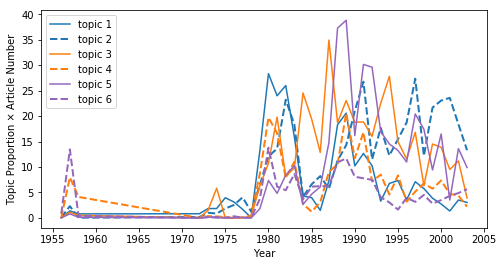

In [75]:
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
plt.figure(figsize=(8, 4))
plt.plot(grouped_df_6['year'], grouped_df_6['t1'], label='topic 1', color = color_sequence[0])
plt.plot(grouped_df_6['year'], grouped_df_6['t2'], label='topic 2', color = color_sequence[0], linestyle = '--', linewidth = 2)
plt.plot(grouped_df_6['year'], grouped_df_6['t3'], label='topic 3', color = color_sequence[2])
plt.plot(grouped_df_6['year'], grouped_df_6['t4'], label='topic 4', color = color_sequence[2], linestyle = '--', linewidth = 2)
plt.plot(grouped_df_6['year'], grouped_df_6['t5'], label='topic 5', color = color_sequence[8])
plt.plot(grouped_df_6['year'], grouped_df_6['t6'], label='topic 6', color = color_sequence[8], linestyle = '--', linewidth = 2)
plt.xticks(np.arange(1955, 2010, step=5))
plt.xlabel("Year")
plt.ylabel("Topic Proportion × Article Number")
plt.legend(loc='best')
plt.show()

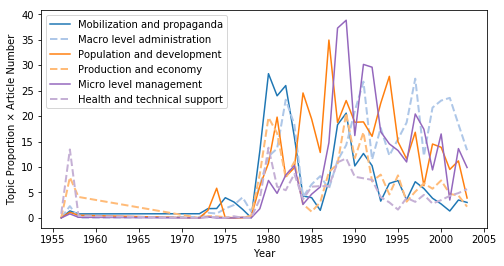

In [147]:
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
plt.figure(figsize=(8, 4))
plt.plot(grouped_df_6['year'], grouped_df_6['t1'], label='Mobilization and propaganda', color = color_sequence[0])
plt.plot(grouped_df_6['year'], grouped_df_6['t2'], label='Macro level administration', color = color_sequence[1], linestyle = '--', linewidth = 2)
plt.plot(grouped_df_6['year'], grouped_df_6['t3'], label='Population and development', color = color_sequence[2])
plt.plot(grouped_df_6['year'], grouped_df_6['t4'], label='Production and economy', color = color_sequence[3], linestyle = '--', linewidth = 2)
plt.plot(grouped_df_6['year'], grouped_df_6['t5'], label='Micro level management', color = color_sequence[8])
plt.plot(grouped_df_6['year'], grouped_df_6['t6'], label='Health and technical support', color = color_sequence[9], linestyle = '--', linewidth = 2)
plt.xticks(np.arange(1955, 2010, step=5))
plt.xlabel("Year")
plt.ylabel("Topic Proportion × Article Number")
plt.legend(loc='best')
#plt.title("The Evolution of Dominant Topics", fontsize=16)
plt.savefig('./visualization/topic_evolution') 
plt.show()

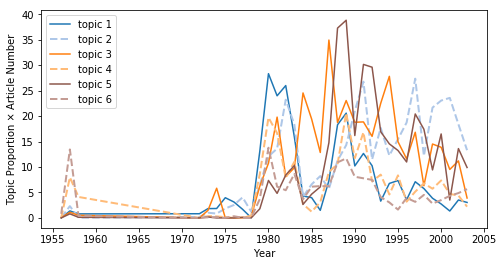

In [81]:
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
plt.figure(figsize=(8, 4))
plt.plot(grouped_df_6['year'], grouped_df_6['t1'], label='topic 1', color = color_sequence[0])
plt.plot(grouped_df_6['year'], grouped_df_6['t2'], label='topic 2', color = color_sequence[1], linestyle = '--', linewidth = 2)
plt.plot(grouped_df_6['year'], grouped_df_6['t3'], label='topic 3', color = color_sequence[2])
plt.plot(grouped_df_6['year'], grouped_df_6['t4'], label='topic 4', color = color_sequence[3], linestyle = '--', linewidth = 2)
plt.plot(grouped_df_6['year'], grouped_df_6['t5'], label='topic 5', color = color_sequence[10])
plt.plot(grouped_df_6['year'], grouped_df_6['t6'], label='topic 6', color = color_sequence[11], linestyle = '--', linewidth = 2)
plt.xticks(np.arange(1955, 2010, step=5))
plt.xlabel("Year")
plt.ylabel("Topic Proportion × Article Number")
plt.legend(loc='best')
plt.show()

In [119]:
# build the function that construct the dataframe for visualization
def construct_vis_df(dataframe, topics):
    # count how frequently a word appears in the document
    data_flat = [w for w_list in dataframe for w in w_list]
    counter = Counter(data_flat)
    # store the word, topic, word weight and word count into a list
    out = []
    for i in range(len(topics)):
        for word, weight in topics[i]:
            out.append([word, i, weight, counter[word]])
    # transform the list into a pandas dataframe
    df = pd.DataFrame(out, columns=['word', 'time_id', 'importance', 'word_count'])  
    
    return df

In [163]:
# evolution of 6th topic
sixth_topic = loaded_model_6.print_topic_times(topic=5) 
sixth_topic

[[('避孕', 0.024958353993967185),
  ('生育', 0.012240566876865163),
  ('节育', 0.01136395385035653),
  ('手术', 0.0099743522639483),
  ('人', 0.009569495594247052),
  ('方法', 0.00865153184814388),
  ('宣传', 0.0074937597797191955),
  ('妇女', 0.007478880020111317),
  ('人工流产', 0.00687648985819623),
  ('工作', 0.0064495710372524055),
  ('健康', 0.006361037397190148),
  ('进行', 0.005790479723050031),
  ('研究', 0.005436328547510161),
  ('节制', 0.005410647100795688),
  ('指导', 0.0052617999388725285),
  ('卫生', 0.005168694540654517),
  ('问题', 0.00504592822947473),
  ('结婚', 0.004887680452638638),
  ('子女', 0.004641663528173049),
  ('影响', 0.0045756407646350885)],
 [('节育', 0.01250525658668799),
  ('手术', 0.011694513882094677),
  ('妇女', 0.009944038427898344),
  ('避孕', 0.009767989399506507),
  ('计划生育', 0.009390010431543439),
  ('研究', 0.00837117033309142),
  ('技术', 0.007806941912858766),
  ('岁', 0.0069955915996157084),
  ('工作', 0.005350919920754696),
  ('人', 0.0050784566170065555),
  ('生育', 0.005012038288365724),
  ('儿童',

In [125]:
#the sixth topic
vis_df_6 = construct_vis_df(processed_df, sixth_topic) 
english_6 = ['Contraception', 'Childbearing', 'Birth control', 'Surgery', 'Human', 'Method', 'Propanganda',
                      'Woman', 'Abortion', 'Work', 'Health', 'Carry out', 'Research', 'Abstinence', 'Guide', 
                       'Hygiene', 'Problem', 'Marry', 'Offspring', 'Influence',
                      'Birth control', 'Surgery', 'Woman', 'Contraception', 'Birth Planning', 'Research', 
                       'Technology', 'Age', 'Work', 'Human', 'Childbearing', 'Children', 'Carry out', 'Our country',
                      'Hygiene', 'Health', 'Hospital', 'Method', 'Personnel', 'Science',
                      'Birth Planning', 'Technology', 'Service', 'Contraception', 'Woman', 'Health', 'Hygiene',
                      'Childbearing', 'Birth control', 'Work', 'Birth', 'Health care', 'Reproduction', 'Rule', 
                      'Country', 'Enhance', 'Personnel', 'Surgery', 'Quality', 'Knowledge']
se_6 = pd.Series(english_6)
vis_df_before_1979["english"] = se_6
times = ["Health and technical support before 1979", "Health and technical support in 1980s", 
         "Health and technical support since 1990s"]

In [151]:
# construct the function to graph Word Counts of Topic Keywords for all 
# topics (reference: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)
def graph_topic_keyword_count(df, topic_name, time_period):
    '''
    Build graphs for the ten topics identified by the lda model based on the
    dataframe, each graph present the counts and weights of the keywords of
    the topic, save the graphs in the visualization folder.

    input: 
        model: the LDA model that identifies the ten topics based on the dataframe
        dataframe: the dataframe used by the LDA model to identify topics
        era: (str) the era of the dataframe (e.g. '70s')
    '''
    
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 1, figsize=(9,9), sharey=True, dpi=100)
    #cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    cols = ['#1f77b4', '#ff7f0e', '#9467bd']
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='english', height="word_count", data=df.loc[df.time_id==i, :],\
                color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='english', height="importance", data=df.loc[df.time_id==i, :],\
                    color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title(time_period[i], color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.time_id==i, 'english'], rotation=40, \
                            horizontalalignment= 'right')
        ax.legend(loc='upper left', bbox_to_anchor=(-0.1, 1.3))
        ax_twin.legend(loc='upper right', bbox_to_anchor=(1.1, 1.3))

    fig.tight_layout(w_pad=2)    
    # save the graphs as files in the visualization folder
    plt.savefig('./visualization/{}_topic_keyword_count_importance'.format(topic_name))   

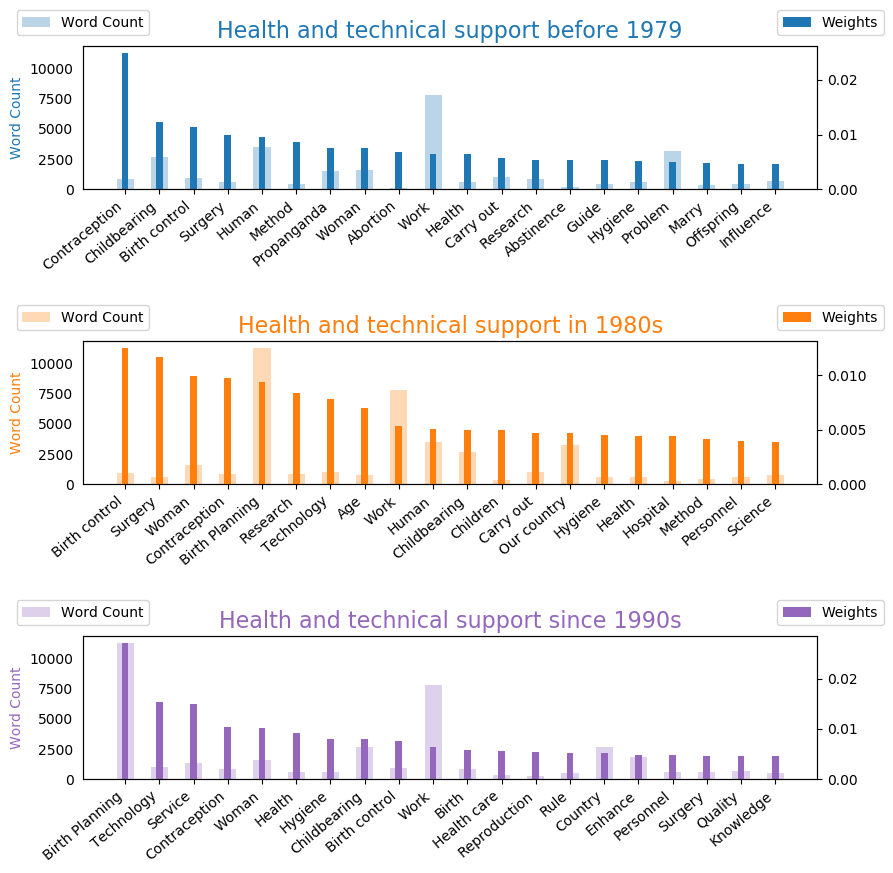

In [165]:
graph_topic_keyword_count(vis_df_6, 'health and technology', times_6)

In [164]:
#the sixth topic
vis_df_6 = construct_vis_df(processed_df, sixth_topic) 
english_6 = ['Contraception', 'Childbearing', 'Birth control', 'Surgery', 'Human', 'Method', 'Propanganda',
                      'Woman', 'Abortion', 'Work', 'Health', 'Carry out', 'Research', 'Abstinence', 'Guide', 
                       'Hygiene', 'Problem', 'Marry', 'Offspring', 'Influence',
                      'Birth control', 'Surgery', 'Woman', 'Contraception', 'Birth Planning', 'Research', 
                       'Technology', 'Age', 'Work', 'Human', 'Childbearing', 'Children', 'Carry out', 'Our country',
                      'Hygiene', 'Health', 'Hospital', 'Method', 'Personnel', 'Science',
                      'Birth Planning', 'Technology', 'Service', 'Contraception', 'Woman', 'Health', 'Hygiene',
                      'Childbearing', 'Birth control', 'Work', 'Birth', 'Health care', 'Reproduction', 'Rule', 
                      'Country', 'Enhance', 'Personnel', 'Surgery', 'Quality', 'Knowledge']
se_6 = pd.Series(english_6)
vis_df_6["english"] = se_6
times_6 = ["Health and technical support before 1979", "Health and technical support in 1980s", 
         "Health and technical support since 1990s"]

In [160]:
# evolution of 1st topic
first_topic = loaded_model_6.print_topic_times(topic=0) 
first_topic

[[('计划生育', 0.020454827271764262),
  ('妇女', 0.014054302394111541),
  ('工作', 0.01305987513505376),
  ('大队', 0.009330334617488981),
  ('思想', 0.008877518311954687),
  ('青年', 0.008561747824567112),
  ('晚婚', 0.007836696991824384),
  ('革命', 0.007430428075030277),
  ('女', 0.007356300935391023),
  ('人', 0.007186450774653743),
  ('孩子', 0.00718300332764597),
  ('生产', 0.007119280698022227),
  ('生', 0.006784641351549463),
  ('实行', 0.006765009893252442),
  ('公社', 0.006377283361060908),
  ('群众', 0.006139829792520575),
  ('社员', 0.005439479443466397),
  ('农业', 0.005417648910648513),
  ('学习', 0.0053542070330738385),
  ('生育', 0.005024925727317897)],
 [('计划生育', 0.0238742696373759),
  ('工作', 0.016446954751593943),
  ('生', 0.015799387520546115),
  ('孩子', 0.01401499257820535),
  ('干部', 0.010870053809701553),
  ('群众', 0.010045314199662887),
  ('夫妇', 0.009067273117542912),
  ('人', 0.008730061195415665),
  ('大队', 0.007065677894157993),
  ('思想', 0.006961279239198513),
  ('胎', 0.006445955191409613),
  ('实行', 0.00

In [161]:
#the first topic
vis_df_1 = construct_vis_df(processed_df, first_topic) 
english_1 = ['Birth planning', 'Woman', 'Work', 'Production brigade', 'Thought', 'Youth', 'Marry late', 'Revolution',
            'Female', 'Human', 'Child', 'Production', 'Bear', 'Carry out', 'Commune', 'The Mass', 
             'Commune member', 'Agriculture', 'Study', 'Childbearing',
            'Birth planning', 'Work', 'Bear', 'Child', 'Official', 'The Mass', 'Couple', 'Human', 
             'Production brigade', 'Thought', 'Fetus', 'Carry out', 'Childbearing', 'Measure', 'Rural village',
            'Production', 'Commune', 'Peasant', 'Education', 'Female',
            'Birth planning', 'Bear', 'Peasant', 'The Mass', 'Insurance', 'Rural village', 'Child', 'Rich', 'RMB yuan',
            'Woman', 'Work', 'Human', 'Childbearing', 'Household', 'Concept', 'Village', "Family", "Couple", "Few",
            "Get rich"]
se_1 = pd.Series(english_1)
vis_df_1["english"] = se_1
times_1 = ["Mobilization and propaganda before 1979", "Mobilization and propaganda in 1980s", 
         "Mobilization and propaganda since 1990s"]

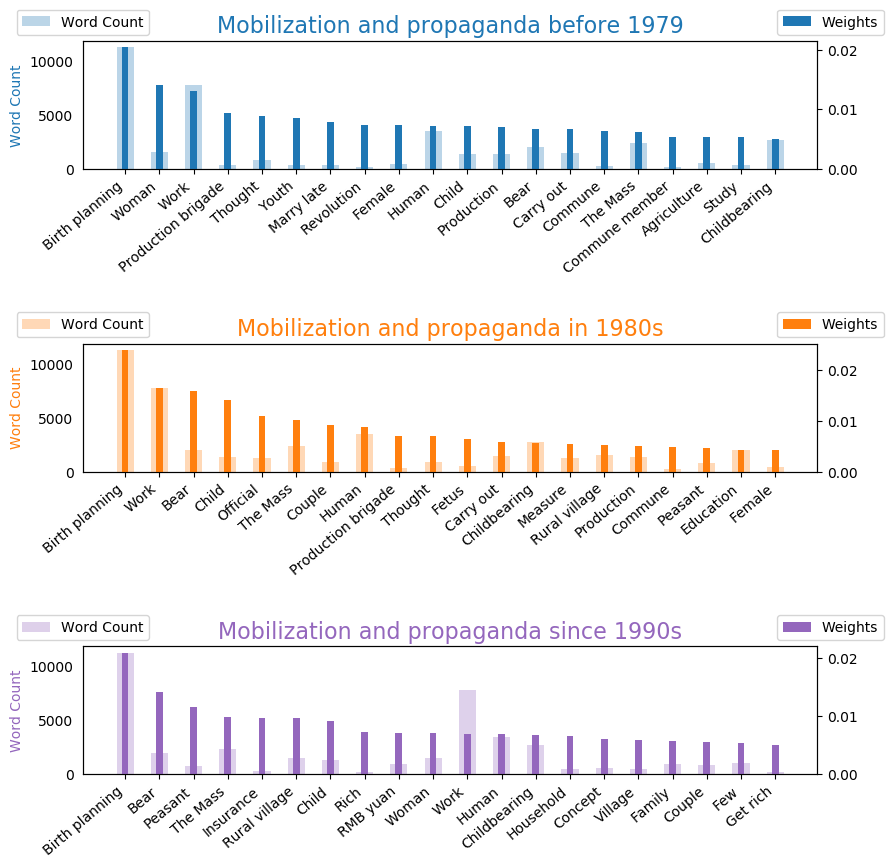

In [162]:
graph_topic_keyword_count(vis_df_1, 'Mobilization and propaganda', times_1)

In [157]:
# evolution of 2nd topic
second_topic = loaded_model_6.print_topic_times(topic=1) 
second_topic

[[('工作', 0.053711404258664795),
  ('计划生育', 0.0421778713022789),
  ('群众', 0.014637337502883829),
  ('宣传', 0.014165124163009739),
  ('人口', 0.01235616292432255),
  ('主席', 0.01087519528905669),
  ('领导', 0.009752470653668556),
  ('计划', 0.00892490119249469),
  ('毛', 0.007934349208648113),
  ('加强', 0.00745973071800059),
  ('开展', 0.007099521700309017),
  ('提高', 0.006886133987258404),
  ('各级', 0.00676693589186748),
  ('社会主义', 0.0065285498412236955),
  ('增长', 0.006019506096204197),
  ('全国', 0.0060040621174545445),
  ('生育', 0.005922490431886806),
  ('重要', 0.005834599907928073),
  ('思想', 0.005735724467928257),
  ('发展', 0.005696076681365156)],
 [('计划生育', 0.05416000036203985),
  ('工作', 0.03846473551892147),
  ('人口', 0.020976090855631645),
  ('宣传', 0.011348236530620278),
  ('控制', 0.010813706247899716),
  ('群众', 0.010623991536684802),
  ('全国', 0.01039965166947375),
  ('我国', 0.010089332386315975),
  ('生育', 0.0076871430019393614),
  ('政策', 0.007425970124268018),
  ('教育', 0.006889441724067072),
  ('实行', 

In [158]:
#the second topic
vis_df_2 = construct_vis_df(processed_df, second_topic) 
english_2 = ['Work', 'Birth Planning', 'The Mass', 'Propaganda', 'Population', 'Chairman', 'Leader', 'Plan', 'Mao',
            'Strengthen', 'Launch', 'Enhance', 'All levels', 'Socialism', 'Increase', 'The whole country', 
             'Childbearing', 'Important', 'Thought', 'Development',
            'Birth Planning', 'Work', 'Population', 'Propaganda', 'Control', 'The Mass', 'The whole country', 
             'Our country', 'Childbearing', 'Policy', 'Education', 'Implement', 'Country', 'Increase', 'The people',
            "Leader", 'Plan', 'All levels', 'Strengthen', 'New',
            'Birth Planning', 'Work', 'Population', 'Development', 'The Mass', 'Environment', 'Society', 
             'The whole country', 'Our country', 'Construction', 'Association', 'New', 'Economy', 'Strengthen', 
            'Problem', 'Enhance', 'Management', 'Counrty', 'Service', 'Control']
se_2 = pd.Series(english_2)
vis_df_2["english"] = se_2
times_2 = ["Macro level administration before 1979", "Macro level administration in 1980s", 
         "Macro level administration since 1990s"]

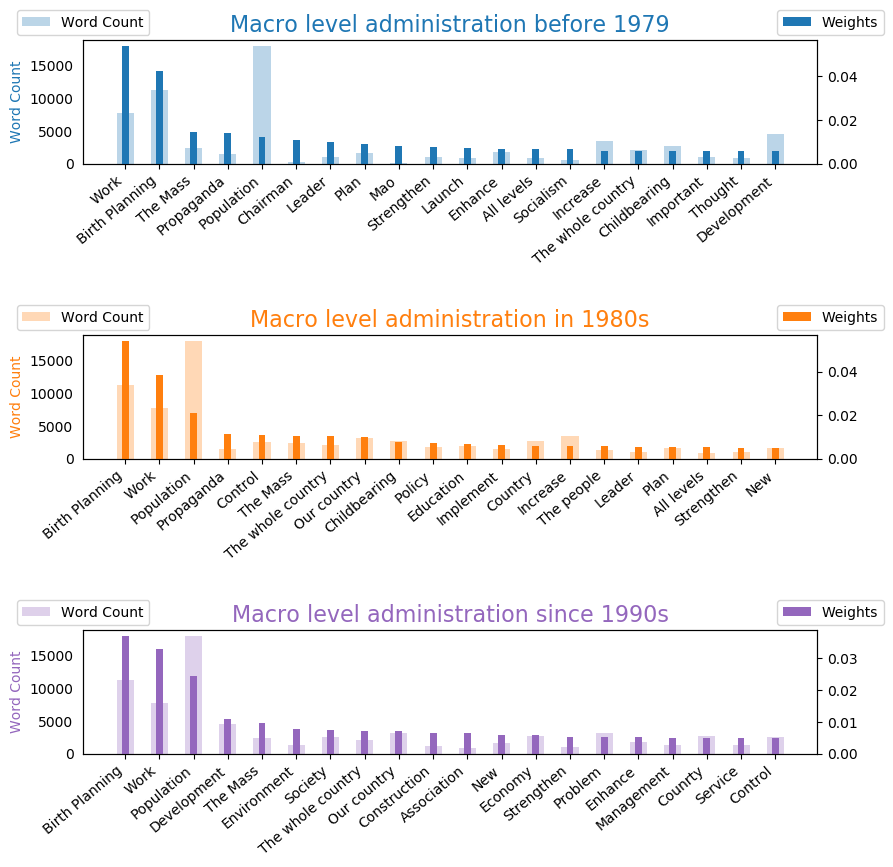

In [159]:
graph_topic_keyword_count(vis_df_2, "Macro level administration", times_2)

In [117]:
# evolution of 3rd topic
third_topic = loaded_model_6.print_topic_times(topic=2) 
third_topic

[[('人口', 0.05107468016840761),
  ('问题', 0.016552666535445744),
  ('国家', 0.01634121850937495),
  ('世界', 0.016066217760607755),
  ('会议', 0.013525456857314381),
  ('人民', 0.01250451721809902),
  ('经济', 0.010848776810814332),
  ('增长', 0.010490480256799582),
  ('代表', 0.010199570432365797),
  ('发展', 0.009965797504449165),
  ('政策', 0.00877722915411041),
  ('中国', 0.007979739929771672),
  ('指出', 0.0068822819322325495),
  ('国际', 0.00655482837635562),
  ('各国', 0.0062476422700607475),
  ('发言', 0.005463288049464248),
  ('社会', 0.004689174982413288),
  ('联合国', 0.004673392760995657),
  ('代表团', 0.00451985788588629),
  ('人', 0.004496692158770371)],
 [('人口', 0.07706877827953719),
  ('中国', 0.019447885160227076),
  ('世界', 0.01611378587303005),
  ('发展', 0.015430931182421552),
  ('国家', 0.01337450633709452),
  ('问题', 0.013121841081566077),
  ('增长', 0.012773096203590252),
  ('政策', 0.008712934444769109),
  ('控制', 0.007903501505361779),
  ('会议', 0.007790139217055292),
  ('联合国', 0.007739110190184455),
  ('计划生育', 0

In [121]:
#the third topic
vis_df_3 = construct_vis_df(processed_df, third_topic) 
english_3 = ['population', 'problem', 'country', 'world', 'conference', 'the people', 'economy', 'growth', 
             'delegate', 'development', 'policy', 'China', 'point out', 'international', 'Every country',
            'speech', 'society', 'UN', 'delegation', 'human',
            'population', 'China', 'world', 'development', 'country', 'problem', 'growth', 'policy', 'control',
            'conference', 'UN', 'birth planning', 'economy', 'Asia', 'international', 'government', 'human',
            'population', 'China', 'world', 'development', 'country', 'problem', 'growth', 'policy', 'control',
            'conference', 'UN', 'birth planning', 'economy', 'Asia', 'international', 'government', 'human',
            'society', 'a hundred million', 'US',
            'population', 'China', 'development', 'world', 'problem', 'growth', 'international', 'a hundred million',
            'country', 'society', 'control', 'economy', 'UN', 'birth planning', 'our counrty', 'conference', 'human',
            'government', 'policy', 'woman']
se_3 = pd.Series(english_3)
vis_df_3["english"] = se_3
times_3 = ["Population and development before 1979", "Population and development in 1980s", 
         "Population and development since 1990s"]

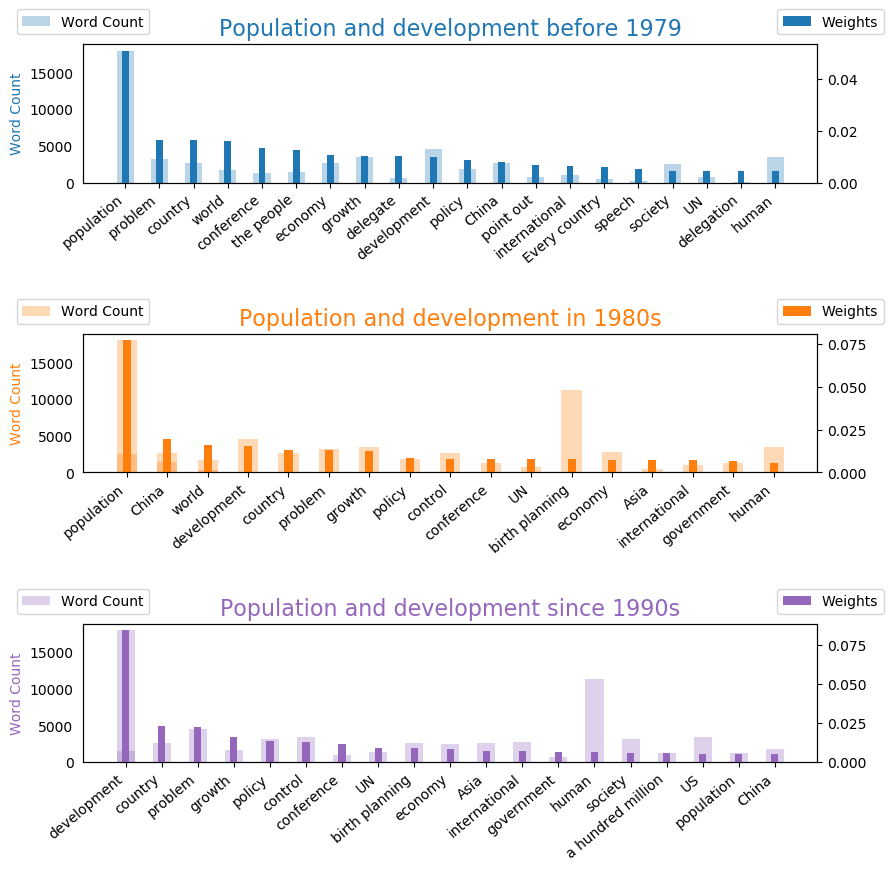

In [154]:
graph_topic_keyword_count(vis_df_3, "Population and development", times_3)

In [123]:
# evolution of 4th topic
fourth_topic = loaded_model_6.print_topic_times(topic=3) 
fourth_topic

[[('人口', 0.025337043936591235),
  ('人', 0.015976909080788408),
  ('我国', 0.013660060343387261),
  ('生产', 0.011153486828940212),
  ('问题', 0.010908672461876674),
  ('增加', 0.009453968171922502),
  ('发展', 0.008044406534709952),
  ('社会主义', 0.0065848855631420134),
  ('生活', 0.006414608848219549),
  ('农业', 0.0063992465568632395),
  ('人民', 0.00634219326266692),
  ('平均', 0.00627273852532048),
  ('工业', 0.0059115466850274715),
  ('建设', 0.005738864012866412),
  ('每年', 0.0055211888950153125),
  ('提高', 0.005159240936324728),
  ('增长', 0.004917153502424192),
  ('元', 0.0048336072512549155),
  ('农民', 0.004743612118842632),
  ('生育', 0.004442045854150715)],
 [('人口', 0.05733003350378742),
  ('增长', 0.01925972162359037),
  ('我国', 0.01588687383419317),
  ('人', 0.013777545499083138),
  ('发展', 0.011356143306896474),
  ('增加', 0.009302898694201586),
  ('平均', 0.00866224591741243),
  ('生产', 0.008368483148228623),
  ('经济', 0.008150510198381188),
  ('控制', 0.008036735133533705),
  ('问题', 0.006855594693059391),
  ('万', 0

In [135]:
#the fourth topic
vis_df_4 = construct_vis_df(processed_df, fourth_topic) 
english_4 = ['population', 'human', 'our country', 'production', 'problem', 'increase', 'development', 'socialism',
            'life', 'agriculture', 'the people', 'average', 'industry', 'construction', 'each year', 'enhance', 
            'growth', 'RMB yuan', 'peasant', 'childbearing',
            'population', 'growth', 'our country', 'human', 'development', 'increase', 'average', 'production', 
             'economy', 'control', 'problem', 'ten thousand', 'a hundred million', 'society', 'level', 'bear',
             'enhance', 'food', 'few', 'childbearing', 
             'population', 'economy', 'development', 'growth', 'our country', 'human', 'society', 'ten thousand', 
             'level', 'few', 'control', 'enhance', 'bear', 'rural village', 'per capita', 'production', 'childbearing',
            'a hundred million', 'increase', 'take up']
se_4 = pd.Series(english_4)
vis_df_4["english"] = se_4
times_4 = ["Production and economy before 1979", "Production and economy in 1980s", 
         "Production and economy since 1990s"]

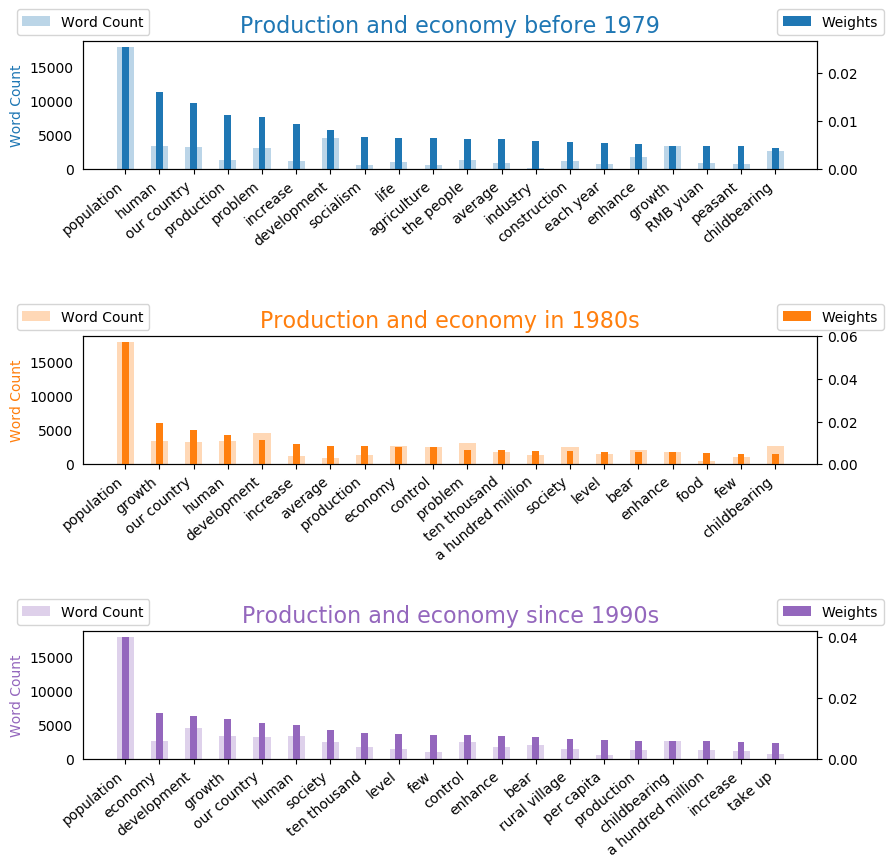

In [153]:
graph_topic_keyword_count(vis_df_4, "Production and economy", times_4)

In [134]:
# evolution of 5th topic
fifth_topic = loaded_model_6.print_topic_times(topic=4) 
fifth_topic

[[('计划生育', 0.024960483884299584),
  ('工作', 0.022134961251181005),
  ('人口', 0.01656903449942782),
  ('全省', 0.009828731439759937),
  ('人', 0.00976626311030112),
  ('生育', 0.009739515220467428),
  ('部门', 0.00799298369131154),
  ('万', 0.007939502435932727),
  ('干部', 0.00742262241830852),
  ('县', 0.006688142428521042),
  ('计划', 0.006050082819645934),
  ('管理', 0.006014913160591428),
  ('流动', 0.005639627192174773),
  ('本报', 0.00558622436602002),
  ('去年', 0.0053347532103603145),
  ('超生', 0.005202914926091099),
  ('人员', 0.0049592503712702594),
  ('育龄', 0.004742492343103341),
  ('市', 0.0043529197067690316),
  ('今年', 0.004295727289147409)],
 [('计划生育', 0.041527154653331504),
  ('人口', 0.018102910322148353),
  ('工作', 0.01794959828523746),
  ('生育', 0.009968014365014176),
  ('人', 0.00993152879098687),
  ('万', 0.008390734747154311),
  ('县', 0.006666676273564743),
  ('管理', 0.006531729719845861),
  ('超生', 0.006247051612158757),
  ('流动', 0.005979725113079482),
  ('干部', 0.005813487378106495),
  ('部门', 0.005

In [137]:
#the fourth topic
vis_df_5 = construct_vis_df(processed_df, fifth_topic) 
english_5 = ['birth planning', 'work', 'population', 'the whole province', 'human', 'childbearing', 'department',
            'ten thousand', 'officials', 'county', 'plan', 'management', 'flow', 'newspaper', 'last year', 
             'prohibited over-birth', 'personnel', 'childbearing age', 'city', 'this year',
            'birth planning', 'population', 'work', 'childbearing', 'human', 'ten thousand', 'county', 'management',
            'prohibited over-birth', 'flow', 'officials', 'department', 'last year', 'plan', 'the whole province', 
            'newspaper', 'childbearing age', 'personnel', 'province', 'out',
            'birth planning', 'population', 'work', 'planning birth', 'management', 'ten thousand', 'flow', 'human',
            'service', 'county', 'education', 'officials', 'the whole country', 'department', 'childbearing', 'plan',
            'newspaper', 'the whole province', 'scientific technology', 'culture']
se_5 = pd.Series(english_5)
vis_df_5["english"] = se_5
times_5 = ["Micro level management before 1979", "Micro level management in 1980s", 
         "Micro level management  since 1990s"]

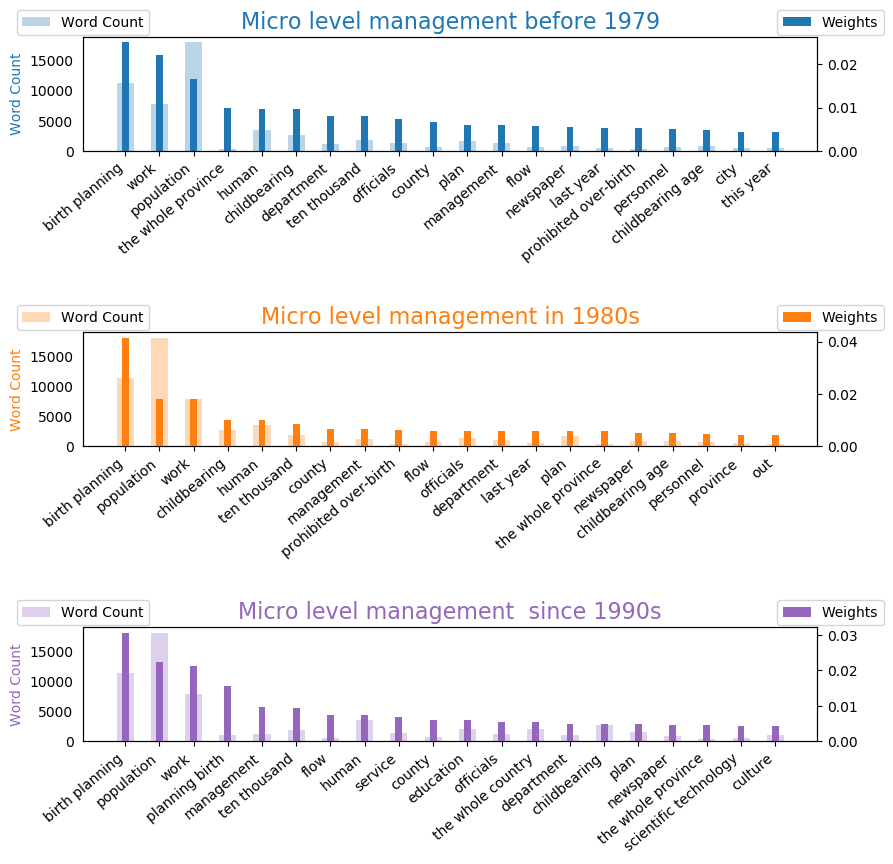

In [152]:
graph_topic_keyword_count(vis_df_5, "Micro level management", times_5)